In [502]:
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
import keras
from keras import backend as K
from keras.layers import Input, Embedding, LSTM, Dense, Conv2D
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, Concatenate
from keras.layers import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from keras.losses import categorical_crossentropy
from keras.layers.advanced_activations import PReLU, LeakyReLU
from keras.optimizers import Adadelta, Nadam, Adam
from sklearn.model_selection import StratifiedKFold
import tensorflow as tf
from tensorflow.python.client import device_lib
import utils
import imp
imp.reload(utils)

IMAGE_HEIGHT, IMAGE_WIDTH = 120, 120
AGE_CLASSES = 100
MAX_SURVIVAL = 2000
CLASSIFICATION = False
SURVIVAL_GROUPS = 4
MAX_SLICES = 10

## Load data

In [211]:
df = pd.read_csv("data/survival_data.csv")
df.head()
orig_X = np.load('data/tumors_small_nz.npy')
orig_X = orig_X.transpose((0, 2, 1, 3, 4))
X = orig_X

if CLASSIFICATION:
    Y = utils.as_classes(df['Survival'], SURVIVAL_GROUPS)
else:
    Y = df['Survival']
df['TumorSum'] = X[:, :3].sum(axis=(1, 2, 3, 4))
df['TumorSum1'] = X[:, 0:1].sum(axis=(1, 2, 3, 4))
df['TumorSum2'] = X[:, 1:2].sum(axis=(1, 2, 3, 4))
df['TumorSum3'] = X[:, 2:3].sum(axis=(1, 2, 3, 4))
df['BrainSum'] = X[:, 3:].sum(axis=(1, 2, 3, 4))

In [153]:
def get_slices_range(patient, min_=1000):
    pixels = patient[0].sum(axis=(1, 2))
    start = next(i for i, val in enumerate(pixels) if val >= min_)
    end = next(i for i, val in reversed(list(enumerate(pixels))) if val >= min_)
    return start, end

slices_ranges = [get_slices_range(patient) for patient in orig_X]
min_range = min((end - start for start, end in slices_ranges))
max_range = max((end - start for start, end in slices_ranges))

## Downsampling Slices

In [ ]:
# Select `min_range` slices for each patient (middle of tumor slices)
downsampled_ix = ((end + start)//2 for start, end in slices_ranges)
downsampled_ix = ((middle - min_range//2, middle + min_range//2) for middle in downsampled_ix)
downsampled = np.array([orig_X[i, :, start:end] for (i, (start, end)) in enumerate(downsampled_ix)])
X = downsampled

## Upsampling Slices

In [222]:
# Repeat tumor until `max_range` reached
upsampled = []
for i, (start, end) in enumerate(slices_ranges):
    sampling = []
    j = 0
    while j < max_range:
        for k in range(start, end+1):
            if j < max_range:
                sampling.append(orig_X[i, :, k:k+1])
                j += 1
    upsampled.append(np.concatenate(sampling, axis=1))
upsampled = np.array(upsampled)
X = upsampled

## Tumor 2D

One pixel contains the sum of slices containing tumor at this position

In [223]:
tumor2D = orig_X[:, :, :, :, :].sum(axis=2)
X = tumor2D

In [ ]:
# Example how this will look in the end, the values are between 0 and 16000
fig, axes = plt.subplots(1, 4, figsize=(16, 4))
for i, ax in enumerate(axes.flat):
    ax.imshow(orig_X[10, i, :, :, :].sum(axis=0))
    ax.set_title('Patient 10, Tumor region {}'.format(i))
axes[-1].set_title('Patient 10, Brain modality #1')
fig.savefig('analysis/tumor_2d.jpg')

## Prepare data

In [224]:
def get_splitted_data(X, ages, labels):
    assert len(X) == len(labels) == len(ages)
    # OneHotEncoding for ages
    enc_table = np.eye(AGE_CLASSES)
    ages_ohe = np.array([enc_table[int(round(x))] for x in ages])
    if not CLASSIFICATION:
        # Normalize labels
        labels /= MAX_SURVIVAL
    # Split data into: 70% train, 15% test, 15% validation
    # cuts = [int(.70*len(X)), int(.85*len(X))]
    # Use all data for training and testing:
    cuts = [int(.9*len(X)), int(1*len(X))]
    X1_train, X1_test, X1_val = np.split(X, cuts)
    X2_train, X2_test, X2_val = np.split(ages_ohe, cuts)
    Y_train, Y_test, Y_val = np.split(labels, cuts)
    return X1_train, X2_train, Y_train, X1_test, X2_test, Y_test, X1_val, X2_val, Y_val

X1_train, X2_train, Y_train, X1_test, X2_test, Y_test, X1_val, X2_val, Y_val = get_splitted_data(
    X, df['Age'], Y)

## Data Analysis

In [ ]:
imp.reload(utils)
utils.plot_tumor_position(X)
utils.plot_pixels_vs_survival(**locals())
utils.plot_age_vs_survival(**locals())
utils.plot_corr(df, 10)
df.corr()

## Run model

##### TODO:
1. Increase Learning rate
2. Increase Drop out
3. Only use tumor image slices
    a. Upsampling -> sample small tumors
    b. Downsampling -> select amount of slices so that it gets only tumor images for each patient
4. Only use one tumor slice
5. One tumor image containing the number of tumor pixels overall slices

In [645]:
def mse(y_true, y_pred):
    return K.mean(K.square(y_pred*MAX_SURVIVAL - y_true*MAX_SURVIVAL), axis=-1)

def build_model():
    main_input = Input(shape=X1_test.shape[1:], dtype='float32', name='main_input')
    if len(X.shape) == 5:
        x = Conv3D(8, (5, 5, 5), padding='same', activation='relu', data_format='channels_first')(main_input)
        x = MaxPooling3D(pool_size=(4, 4, 4))(x)
        x = Dropout(0.25)(x)
        x = Conv3D(8, (3, 3, 3), padding='same', activation='relu', data_format='channels_first')(x)
        x = MaxPooling3D(pool_size=(4, 4, 4))(x)
        x = Dropout(0.15)(x)
    else:
        x = Conv2D(32, (5, 5), padding='same', data_format='channels_first')(main_input)
        x = MaxPooling2D(pool_size=(4, 4))(x)
        x = Activation(LeakyReLU())(x)
        x = Dropout(0.5)(x)
        x = Conv2D(64, (3, 3), padding='same', data_format='channels_first')(x)
        x = MaxPooling2D(pool_size=(4, 4))(x)
        x = Activation(PReLU())(x)
        x = Dropout(0.5)(x)

    x = Dense(128, activation='tanh')(x)
    cnn_out = Flatten()(x)
    x = Dense(64, activation='sigmoid')(x)
    auxiliary_output = Dense(1, activation='sigmoid', name='aux_output')(cnn_out)

    auxiliary_input = Input(shape=(AGE_CLASSES,), name='aux_input', dtype='float32')
    x = Dense(AGE_CLASSES//2, activation='tanh')(auxiliary_input)
    x = Dropout(0.3)(x)
    x = keras.layers.concatenate([cnn_out, x])
    x = Dense(128, activation='tanh')(x)
    x = Dense(128, activation='sigmoid')(x)
    main_output = Dense(1, dtype='float32', activation='sigmoid', name='main_output')(x)
    model = Model(inputs=[main_input, auxiliary_input], outputs=[main_output, auxiliary_output])
    optimizer = Adam(lr=0.001)
    model.compile(optimizer=optimizer, metrics=[mse],
                  loss={'main_output': 'mean_squared_error', 'aux_output': 'mean_squared_error'},
                  loss_weights={'main_output': 1, 'aux_output': 0})
    return model

In [646]:
def train_model(train, test, epochs=20, verbose=1, batch_size=32):
    input1_train, input2_train, output_train = train
    input1_test, input2_test, output_test = test
    with tf.device('/gpu:0'):
        model = build_model()
        history = keras.callbacks.History()
        try:
            model_results = model.fit(
                {'main_input': input1_train, 'aux_input': input2_train},
                {'main_output': output_train, 'aux_output': output_train},
                epochs=epochs, batch_size=batch_size, verbose=verbose,
                validation_data=({'main_input': input1_test, 'aux_input': input2_test},
                                 {'main_output': output_test, 'aux_output': output_test}),
                callbacks=[history])
        except KeyboardInterrupt:
            model_results = None
            pass
    return model, model_results

model, model_results = train_model((X1_train, X2_train, Y_train), (X1_test, X2_test, Y_test))

Train on 146 samples, validate on 17 samples
Epoch 1/20
146/146 [==============================] - 12s - loss: 0.0602 - main_output_loss: 0.0602 - aux_output_loss: 0.0766 - main_output_mse: 240787.4293 - aux_output_mse: 306501.0771 - val_loss: 0.0518 - val_main_output_loss: 0.0518 - val_aux_output_loss: 0.0293 - val_main_output_mse: 207347.7812 - val_aux_output_mse: 117355.3125
Epoch 2/20
146/146 [==============================] - 4s - loss: 0.0362 - main_output_loss: 0.0362 - aux_output_loss: 0.0833 - main_output_mse: 144908.6993 - aux_output_mse: 333120.2256 - val_loss: 0.0205 - val_main_output_loss: 0.0205 - val_aux_output_loss: 0.0333 - val_main_output_mse: 81965.3750 - val_aux_output_mse: 133350.4062
Epoch 3/20
146/146 [==============================] - 4s - loss: 0.0377 - main_output_loss: 0.0377 - aux_output_loss: 0.0761 - main_output_mse: 150741.6351 - aux_output_mse: 304529.1391 - val_loss: 0.0239 - val_main_output_loss: 0.0239 - val_aux_output_loss: 0.0412 - val_main_output_m

('Test mse:', 109959.0390625)
Predictions on training set: 
[ 379.]
[  104.   114.   130.   131.   132.   140.   154.   164.   165.   182.
   199.   203.   208.   217.   226.   228.   234.   237.   241.   247.
   249.   253.   256.   259.   260.   261.   262.   263.   264.   269.
   276.   278.   285.   288.   299.   304.   314.   324.   328.   332.
   337.   341.   346.   347.   350.   352.   354.   357.   359.   362.
   373.   377.   380.   389.   395.   399.   401.   406.   409.   415.
   417.   418.   422.   426.   427.   429.   430.   431.   435.   445.
   446.   447.   450.   453.   454.   457.   459.   461.   463.   466.
   472.   476.   478.   482.   483.   487.   501.   504.   506.   509.
   510.   513.   517.   518.   526.   527.   528.   535.   538.   547.
   556.   560.   563.   569.   598.   605.   620.   623.   626.   646.
   647.   650.   653.   666.   674.   688.   729.   733.   755.   763.
   804.   810.   818.   821.   889.  1021.  1029.]


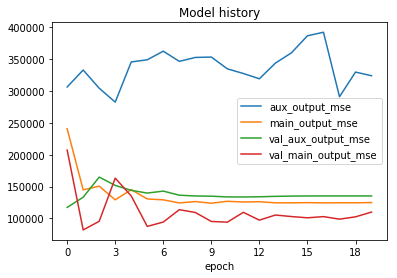

In [651]:
imp.reload(utils)
# Evaluate model on validation set
val_score = model.evaluate({'main_input': X1_test, 'aux_input': X2_test},
                                           {'main_output': Y_test, 'aux_output': Y_test}, verbose=0)
print('Test mse:', val_score[-2])
utils.plot_history(model_results, filename=None)  # 'analysis/model_history.jpg')

utils.plot_model(model, 'analysis/model.jpg')
print('Predictions on training set: ')
predicted = model.predict({'main_input': X1_train, 'aux_input': X2_train})
print(np.unique(np.round(np.array(predicted)[0, :, 0] * MAX_SURVIVAL)))
print(np.unique(np.round(np.array(predicted)[1, :, 0] * MAX_SURVIVAL)))

- 2 Conv(32[5x5x5], 64[3x3x3x]), 3 version (only tumor regions) -> Get's stuck at "loss: 0.0798 - val_loss: 0.0534"
- Increase/Add dropout before and after the concatenation -> The same
- Add conv layer (16, 32, 64) -> Get's stuck at "loss: 0.6524 - val_loss: 0.6997"
- Use 7 versions (includes modalities) -> The same
- Use Downsampling or Tumor2D -> Gets stuck at "loss: 0.0798 - val_loss: 0.0534"
- Switch from Adam to Nadam optimizer -> The same (Nadam changes between first and second epoch)
- Again Adam, Adding auxiliary output -> Epoch 1: "loss: 0.4143 - val_loss: 0.3765" -> at epoch 6 gets stuck at "loss (both): 0.0798 val_loss(both): 0.0534" (stop after 12 epochs)
- Add manual Adam, Again use Tumor2D -> Epoch 1: "loss: 0.3889 - val_loss: 0.3765" -> gets stuck after second epoch (loss: 0.3661, val_loss as in epoch 1)
- Switch back to 'Adam' -> Gets stuck at "loss: 0.0798"
- Try out different hyperparameters for Adam doesn't improve the results
- Nadam -> Again "loss: 0.0798"
- Rmsprop -> Gets stuck after increasing loss at epoch 3: "loss: 0.3661
- Adadelta -> Gets stuck at "loss: 0.6524"
- Stay at Adam, Increase/Decrease Dropout, Add Layers, Change order -> Best results still: "loss: 0.0798"
- Upsampling: "loss: 0.0798 - val_loss: 0.0534, main_output_mse: 319091.6469, val_main_output_mse: 213686.8281" (stuck after second epoch)

In [ ]:
# N-fold cross validation
# 1.) http://machinelearningmastery.com/evaluate-performance-deep-learning-models-keras/
# 2.) https://datascience.stackexchange.com/questions/11747/cross-validation-in-keras
results = []
best_model = None
best_value = 150000
def n_fold_cross_validation(folds=10):
    global best_model, best_value
    step = float(X.shape[0]) / folds
    enc_table = np.eye(AGE_CLASSES)
    ages_ohe = np.array([enc_table[int(round(x))] for x in df['Age']])
    # Normalize labels
    labels = df['Survival'] / MAX_SURVIVAL
    for i in range(folds):
        cuts = [int(step*i), int(step*(i+1))]
        X1_train_front, X1_test, X1_train_back = np.split(X, cuts)
        X2_train_front, X2_test, X2_train_back = np.split(ages_ohe, cuts)
        Y_train_front, Y_test, Y_train_back = np.split(labels, cuts)
        X1_train = np.concatenate([X1_train_front, X1_train_back])
        X2_train = np.concatenate([X2_train_front, X2_train_back])
        Y_train = np.concatenate([Y_train_front, Y_train_back])
        print("Train model...")
        model, model_results = train_model((X1_train, X2_train, Y_train), (X1_test, X2_test, Y_test), epochs=20, verbose=0)
        if model_results is None:
            # Cause by KeyboardInterrupt
            return results, None
        val_score = model.evaluate({'main_input': X1_test, 'aux_input': X2_test},
                                           {'main_output': Y_test, 'aux_output': Y_test}, verbose=0)
        print(val_score)
        test_mse = val_score[-2]
        if test_mse < best_value:
            best_value = test_mse
            best_model = model
            print("Updated best model")
        print("Test MSE in run {}: {}".format(i, test_mse))
        predicted = model.predict({'main_input': X1_train, 'aux_input': X2_train})
        print("Unique predicted values: {}".format(' '.join(
            np.unique([str(x) for x in np.round(np.array(predicted)[0, :, 0] * MAX_SURVIVAL)]))))
        results.append(test_mse)
    return results, np.mean([x**2 for x in results])

results2, cv_mse = n_fold_cross_validation()

Train model...
[0.034528233110904694, 0.034528233110904694, 0.095063053071498871, 138112.9375, 380252.21875]
Updated best model
Test MSE in run 0: 138112.9375
Unique predicted values: 458.0
Train model...
[0.019342562183737755, 0.019342562183737755, 0.25852763652801514, 77370.2578125, 1034110.4375]
Updated best model
Test MSE in run 1: 77370.2578125
Unique predicted values: 417.0
Train model...
[0.043294474482536316, 0.043294474482536316, 0.31938618421554565, 173177.90625, 1277544.75]
Test MSE in run 2: 173177.90625
Unique predicted values: 440.0
Train model...


In [664]:
# Check X vs labels?
imp.reload(utils)
predicted = model.predict({'main_input': X1_val, 'aux_input': X2_val})
predicted = np.array(predicted)[0, :, 0]
predicted *= MAX_SURVIVAL
utils.plot_samples(X1_val, X2_val.argmax(axis=1), Y_val.values * MAX_SURVIVAL, predicted=predicted, samples=10, seed=10)

IndexError: too many indices for array

In [331]:
def mse(X1, X2, Y, verbose=False):
    sum_ = 0
    for i in range(len(X1)):
        prediction = model.predict({'main_input': X1[i:i+1], 'aux_input': X2[i:i+1]})
        prediction = prediction[0][0][0] * MAX_SURVIVAL  # Select main_output
        gt = Y.values[i] * MAX_SURVIVAL
        if verbose:
            print('Age: {}, GT: {}, Prediction: {}'.format(
                X2[i].argmax(),
                gt,
                prediction))
        sum_ += float(gt - prediction)**2
    return 'MSE: {}'.format(sum_ / len(X1))

print('train: {}'.format(mse(X1_train, X2_train, Y_train)))
print('test: {}'.format(mse(X1_test, X2_test, Y_test, verbose=True)))
# print('val: {}'.format(mse(X1_val, X2_val, Y_val, verbose=True)))

train: MSE: 124763.963416
Age: 58, GT: 439.0, Prediction: 383.974432945
Age: 56, GT: 368.0, Prediction: 384.191215038
Age: 63, GT: 169.0, Prediction: 383.958101273
Age: 52, GT: 359.0, Prediction: 384.108781815
Age: 60, GT: 698.0, Prediction: 383.945643902
Age: 66, GT: 495.0, Prediction: 383.993029594
Age: 61, GT: 421.0, Prediction: 383.887529373
Age: 48, GT: 515.0, Prediction: 384.235411882
Age: 56, GT: 1155.0, Prediction: 384.250968695
Age: 68, GT: 1278.0, Prediction: 384.145230055
Age: 70, GT: 503.0, Prediction: 383.997350931
Age: 67, GT: 269.0, Prediction: 384.050935507
Age: 68, GT: 465.0, Prediction: 384.080737829
Age: 39, GT: 788.0, Prediction: 383.932888508
Age: 54, GT: 464.0, Prediction: 384.007513523
Age: 52, GT: 616.0, Prediction: 384.15491581
Age: 60, GT: 289.0, Prediction: 384.308725595
test: MSE: 108178.730748


### 163 patients with tumor images of sizes 240x240 of which we have 155

### Start
Implementing a concatenated model as shown in the Docs: https://keras.io/getting-started/functional-api-guide/#multi-input-and-multi-output-models
The model uses a small common CNN for processing one patient (155 slices x 128 width x 128 height) and just inserts the age at a certain point. With this simple model we get really bad results (main_output_loss: 263381.5156 [not getting better]).


### Possible improvements
1. ~~Conv3D (in CNN) which gets a 4D input - therefore add the tumor region as a dimension (transform input image into three images containing each tumor region seperately~~)
2. ~~One-hot encoder (in sklearn or implement manually)
  [ I tried Keras Lambda layer but after fixing the shapes keras told me that I'm not allowed to concatenate with a non input layer ]~~
3. ~~Add modalities, rescale images (8GB -> 2GB)~~
4. Group survival rate into few classes changing the regression task into a classification task (with softmax).
5. Evaluate if LSTM is useful for this task (before concatenating the two branches or as a concatenator?)
6. ~~Evaluate our optimizer (RMSprp vs Adam vs AdaDelta)
    -> RMSprop doesn't learn at all (Adam does!)
    -> First run was without normalization but no improvement (After normalization quite good results)~~
7. I red full batch learning is the best way for training on few training data - check if this is helpful.
8. Use for a patient nx, ny and nz at the same time
9. Data augmentation?
10. ~~Check if the dimension are correctly set for the conv3d layers - i got the feeling, that the first dimension are the modalities/results instead of the slices.~~

##### Optimizer:
RMSprop uses:
    - Momentum taking knowledge from previous steps into account about where we should be heading
        (prevents gradient descent to oscillate)
    - Uses recent gradients to adjust alpha (when the gradient is very large, alpha is reduced and vice-versa)
    - Later we should test if AdaDelta or Adam are improving our results (quite similar to RMSprop)